## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [676]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [677]:
df= pd.read_csv('ab_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.to_period('D')
df.head()

user_id   timestamp      group landing_page  converted
0   851104  2017-01-21    control     old_page          0
1   804228  2017-01-12    control     old_page          0
2   661590  2017-01-11  treatment     new_page          0
3   853541  2017-01-08  treatment     new_page          0
4   864975  2017-01-21    control     old_page          1

b. Use the below cell to find the number of rows in the dataset.

In [678]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [679]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [680]:
(df['converted']==1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [681]:
a = df.query('group == "treatment" and landing_page != "new_page"').count() 
b = df.query('group == "control" and landing_page == "new_page"').count()
a+b

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [682]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [683]:
df2 = df[(df['group'] == 'treatment') == (df['landing_page'] == 'new_page')]
df2.count() + 3893
##df.count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

In [684]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [685]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [686]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [687]:
df2[df2['user_id'].duplicated()]

user_id   timestamp      group landing_page  converted
2893   773192  2017-01-14  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [688]:
df2.drop_duplicates('user_id', inplace = True)

C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [689]:
(df2['converted']==1).mean()


0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [690]:
cont_prob = df2.query('group == "control"')['converted'].mean()
cont_prob

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [691]:
treat_prob = df2.query('group == "treatment"')['converted'].mean()
treat_prob

0.11880806551510564

d. What is the probability that an individual received the new page?

In [692]:
df2.query('landing_page == "new_page"')['landing_page'].count()/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Since the conversion rate is higher in the control group given a similar sample size, it does not seem likely that the new page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null: The control group has a converted rate that is equal to or greater than the converted rate of the treatment group.
Alternative:  The treatment group has a higher converted rate than the control group.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [693]:
pnew = (df2['converted']==1).mean()
pnew

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [694]:
pold = (df2['converted']==1).mean()
pold

0.11959708724499628

c. What is $n_{new}$?

In [695]:
nnew = df2.query('group=="treatment"')['group'].count()
nnew

145310

d. What is $n_{old}$?

In [696]:
nold = df2.query('group=="control"')['group'].count()
nold

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [697]:
new_page_converted = np.random.choice([0,1], nnew, pnew)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [698]:
old_page_converted =   np.random.choice([0,1], nold, pold)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [699]:
new_page_converted.mean() - old_page_converted.mean()

-0.0006397773749914903

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [706]:
samp_new = np.random.binomial( nnew, pnew, 10000 ) / nnew 
samp_old = np.random.binomial( nold, pold, 10000 ) / nold 
p_diffs = samp_new - samp_old
p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00140867, -0.00175003, -0.00166771, ..., -0.00082794,
       -0.00021562,  0.00143638])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

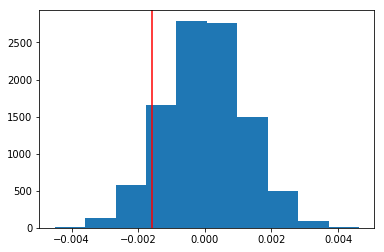

In [707]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c='red')

In [708]:
obs_diff = treat_prob-cont_prob
(p_diffs> obs_diff).mean()


0.9039

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The p-value is calculated above. This means that there is approximately a 90% chance that the observed values came from groups that have either an equal converted rate or where the converted rate in the control group is higher than the treatment group. This result does not show that the new page is better at a Type I error rate of 5%.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [709]:
import statsmodels.api as sm

convert_old = df2.query('group =="control"')['converted'].sum()
convert_new = df2.query('group =="treatment"')['converted'].sum()
n_old = df2.query('group == "control"')['converted'].count()
n_new = df2.query('group == "treatment"')['converted'].count()
convert_new
convert_old

17489

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [710]:
sm.stats.proportions_ztest(count = [convert_old, convert_new], nobs = [n_old, n_new], alternative='smaller')


(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value = 0.905 and the z-score is 1.31. The test did not reach the threshhold for statistical significance. There is not evidence to support overturning the null hypothesis. 
The p-values are very similar, but the first one varies slightly with each random sample. The observed difference in means is 1.3 standard deviations from the mean of the means of the differences between the groups under the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [711]:
df2['intercept'] = 1
dum_df = pd.get_dummies(df2['group'])
df2['ab_page'] = dum_df['treatment']
df2.head()

C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


user_id   timestamp      group landing_page  converted  intercept  ab_page
0   851104  2017-01-21    control     old_page          0          1        0
1   804228  2017-01-12    control     old_page          0          1        0
2   661590  2017-01-11  treatment     new_page          0          1        1
3   853541  2017-01-08  treatment     new_page          0          1        1
4   864975  2017-01-21    control     old_page          1          1        0

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [712]:
logm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = logm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [713]:
np.exp(-0.0150)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        11:53:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p- value is 0.19. This is because it is a two tailed test. The null hypothesis is that the treatment group is equal to the control group. Under this hypothesis, results that indicate that the new page is superior or inferior to the old page would allow us to reject the null hypothesis. In the previous hypothesis, only results that suggest that the new page is superior than the old page will allow us to reject the null hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

***The experiment with landing pages is not very helpful in helping us understanding how to influence conversion rate. And because we want to better understand conversion rate, it may be useful to try another factor. However, adding other factors has some potential problems. For example, if variables are correlated with each other, the resulting coefficients might be misleading. Sometimes making a model too complex will produce results that lead us to an interpretation that does not reflect the truth of the population.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [714]:
##countries_df = pd.read_csv('./countries.csv')
##df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

df3 = pd.read_csv('countries.csv')
df3['country'].value_counts()
dum_df2 = pd.get_dummies(df3['country'])
df3[['uk', 'ca']] = dum_df2[['UK', 'CA']]
df4 = df2.join(df3.set_index('user_id'), on= 'user_id', how= 'inner')


In [715]:
logm2 = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'uk', 'ca']])
res2 = logm2.fit()
res2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 11 Apr 2019   Pseudo R-squ.:               2.323e-05
Time:                        11:54:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
uk             0.0099      0.013      0.743      0.457      -0.016       0.036
ca            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

**The result of the regression does not provide support for the hypothesis that country has an impact on converted rates. Although the coefficients are different, the p-values are too high for us to draw conclusions.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [716]:
ca = (df4['ca']*df4['ab_page'])
uk = (df4['uk']* df4['ab_page'])
df4['ca_page_combined']= ca
df4['uk_page_combined']= uk
df4.head()

user_id   timestamp      group landing_page  converted  intercept  ab_page  \
0   851104  2017-01-21    control     old_page          0          1        0   
1   804228  2017-01-12    control     old_page          0          1        0   
2   661590  2017-01-11  treatment     new_page          0          1        1   
3   853541  2017-01-08  treatment     new_page          0          1        1   
4   864975  2017-01-21    control     old_page          1          1        0   

  country  uk  ca  ca_page_combined  uk_page_combined  
0      US   0   0                 0                 0  
1      US   0   0                 0                 0  
2      US   0   0                 0                 0  
3      US   0   0                 0                 0  
4      US   0   0                 0                 0

In [717]:
logm3 = sm.Logit(df4['converted'], df4[['intercept', 'uk_page_combined', 'ca_page_combined']])
res3 = logm3.fit()
res3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Apr 2019   Pseudo R-squ.:               2.364e-05
Time:                        11:54:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.08085
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -1.9963      0.006   -322.049      0.000      -2.008      -1.984
uk_page_combined     0.0149      0.017      0.862      0.389      -0.019       0.049
ca_page_combined    -0.0752      0.038     -1.997      0.046      -0.149      -0.001
====================================================================================
"""

**If only the interaction variables are included in the model, whe summary suggests that the relationship between the landing page and converted rates may depend on the country that was sampled. The relationship in The US is not equal to the relationship in Canada with a type I error rate of 4.6%.**

In [718]:
np.exp(-0.0752)

0.92755795618492

**Because previous analysis has not provided very useful insights about variables associated with conversion rates, I tried another variable. I was curious about whether it mattered what day of the week the sample came from. I made dummy variables with the days of the week to see whether I could find any statistically significant associations. The null hypothesis is: The conversion rate on Monday is equal to each of the other days of the week.** 

In [719]:
df2['day_of_week'] = df2['timestamp'].dt.dayofweek

C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [720]:
dum_df4 = pd.get_dummies(df2['day_of_week'])

df2[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']] = dum_df4

In [721]:
logm4 = sm.Logit(df2['converted'], df2[['intercept', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']])
res4 = logm4.fit()
res4.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Thu, 11 Apr 2019   Pseudo R-squ.:               2.601e-05
Time:                        11:55:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4774
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9816      0.014   -137.832      0.000      -2.010      -1.953
tuesday       -0.0152      0.020     -0.753      0.452      -0.055       0.024
wednesday     -0.0077      0.021     -0.364      0.716      -0.049       0.034
thursday      -0.0112      0.021     -0.529      0.597      -0.053       0.030
friday        -0.0425      0.021     -2.002      0.045      -0.084      -0.001
saturday      -0.0030      0.021     -0.145      0.885      -0.044       0.038
sunday        -0.0253      0.021     -1.199      0.231      -0.067       0.016
==============================================================================
"""

**The result for Friday reaches statistical significance. This allows us to reject the null hypothesis that the conversion rate on Monday is equal to the conversion rate on Friday. The model suggests that the conversion rate is lower on Friday.
The exponential of the coefficient is 0.958. The practical significance is unclear as it is not obvious how this difference could be relevant to any strategies for increasing conversion.**

In [722]:
np.exp(-0.0425)

0.958390465520947

**The test ran for approximately three weeks. Would the results be different if we had stopped the experiment after only one week? I repeated the steps above to find the p-values for the test results after one week.**

In [723]:
df['timestamp'].min()
df5 = df2.query('timestamp < "2017-01-10"')
df2['timestamp'].min()
prob2 = (df5['converted']==1).mean()
nnew2 = df5.query('group=="treatment"')['group'].count()
nold2 = df5.query('group=="control"')['group'].count()

In [724]:
logm5 = sm.Logit(df5['converted'], df5[['intercept', 'ab_page']])
res5 = logm5.fit()
res5.summary()

Optimization terminated successfully.
         Current function value: 0.364254
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                98167
Model:                          Logit   Df Residuals:                    98165
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Apr 2019   Pseudo R-squ.:               8.673e-06
Time:                        11:55:59   Log-Likelihood:                -35758.
converged:                       True   LL-Null:                       -35758.
                                        LLR p-value:                    0.4309
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9974      0.014   -143.377      0.000      -2.025      -1.970
ab_page       -0.0155      0.020     -0.788      0.431      -0.054       0.023
==============================================================================
"""

The p-value is much higher in the two tailed test when the test is stopped after one week than when it continues for three weeks. If the experiment was run for longer than three weeks, perhaps the p-value would drop even further. Regardless, it seems sufficiently clear that the new-page is not going to be useful for our goal of increasing converted rates. 

Below, I found the p-value by repeating the other two methods, and found a consistent p-value for a one tailed test. 

In [725]:
samp_new2 = np.random.binomial( nnew2, prob2, 10000 ) / nnew2 
samp_old2 = np.random.binomial( nold2, prob2, 10000 ) / nold2
p_diffs2 = samp_new2 - samp_old2
p_diffs2 = np.array(p_diffs2)
obs_diff2 = df5.query('group == "treatment"')['converted'].mean() - df5.query('group == "control"')['converted'].mean()

In [726]:
(p_diffs2> obs_diff2).mean()

0.786

In [727]:
convert_old2 = df5.query('group =="control"')['converted'].sum()
convert_new2 = df5.query('group =="treatment"')['converted'].sum()
n_old2 = df5.query('group == "control"')['converted'].count()
n_new2 = df5.query('group == "treatment"')['converted'].count()
sm.stats.proportions_ztest(count = [convert_old2, convert_new2], nobs = [n_old2, n_new2], alternative = 'smaller')

(0.787579833847064, 0.7845287428540484)

I was unsure about what this meant. I thought I would try to compare that data sets to each other to see if there was reason to believe that they were different from each other. I decided to just compare the treatment groups of the full and partial data sets. They do not appear to be different. 

In [728]:
convert_new2 = df5.query('group =="treatment"')['converted'].sum()
convert_new = df2.query('group =="treatment"')['converted'].sum()
n_new2 = df5.query('group == "treatment"')['converted'].count()
n_new = df2.query('group == "treatment"')['converted'].count()

sm.stats.proportions_ztest(count = [convert_new, convert_new2], nobs = [n_new, n_new2])


(0.565777108031666, 0.571545310107774)

<a id='conclusions'></a>
## Conclusions

We will not implement the new landing page based on the data that we have. Perhaps there is reason to explore differences in countries more, if the possibility exists for us to implement landing pages based on country. 
We may also try to start over with a new landing page design and try again. 
Otherwise, we will need to find other strategies to increase conversion. 
### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.